<a href="https://colab.research.google.com/github/SaiNikhil-06/Fake-Job-Listing-Detection/blob/main/FakeJobPostingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
df=pd.read_csv(r'/content/drive/MyDrive/Fake Job Posting/fake_job_postings.csv')

In [7]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
!pip install wordcloud

In [10]:
!pip install -U spacy

     |████████████████████████████████| 12.8MB 328kB/s 
     |████████████████████████████████| 9.1MB 24.2MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 1.1MB 41.4MB/s 
     |████████████████████████████████| 460kB 43.6MB/s 
     |████████████████████████████████| 122kB 59.5MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=64a5ca1248afb2f367dd0afc3c38eacb33c852356d6577845518c9461056a7e3
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: smart-open 5.0.0
    Uninstalling smart-open-5.0.0:
      Successfully uninstalled smart-open-5.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-

In [11]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [12]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [13]:
df.shape

(17880, 18)

In [14]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type'] #these features can be deleted as no use of numerics for NLP model
for col in columns:
    del df[col]

In [15]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [16]:
df.isna().sum()

title                      0
location                 346
department             11547
company_profile         3308
description                1
requirements            2695
benefits                7210
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [17]:
df.fillna('',inplace=True)

In [21]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [18]:
df.isna().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

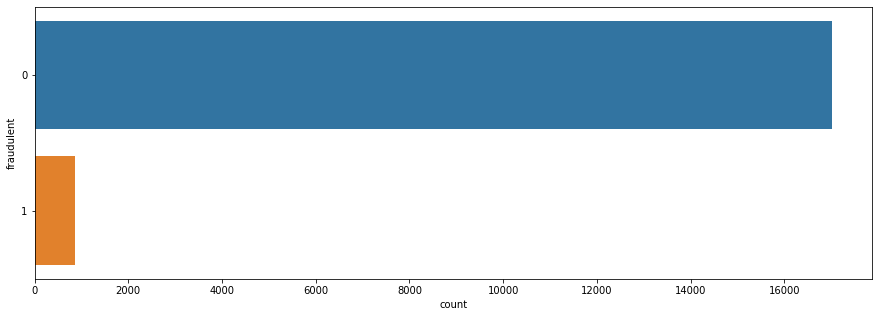

In [19]:
#graphival analyssis 
plt.figure(figsize=(15,5))
sns.countplot(y='fraudulent',data=df)
plt.show()

In [20]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [23]:
exp = dict(df.required_experience.value_counts())
exp

{'': 7050,
 'Associate': 2297,
 'Director': 389,
 'Entry level': 2697,
 'Executive': 141,
 'Internship': 381,
 'Mid-Senior level': 3809,
 'Not Applicable': 1116}

In [24]:
del exp['']

In [25]:
exp

{'Associate': 2297,
 'Director': 389,
 'Entry level': 2697,
 'Executive': 141,
 'Internship': 381,
 'Mid-Senior level': 3809,
 'Not Applicable': 1116}

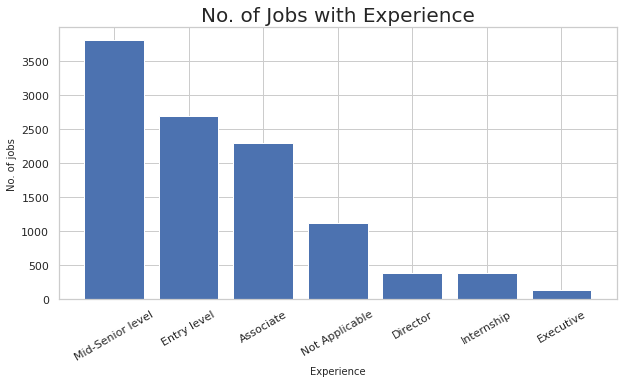

In [26]:
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
plt.bar(exp.keys(), exp.values())
plt.title('No. of Jobs with Experience',size=20)
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=30)
plt.show()

In [27]:
def split(location):
    l = location.split(',')
    return l[0]
df['country'] = df.location.apply(split)

In [28]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [29]:
df['text']=df['title']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

In [30]:
df['text']

0        Marketing Intern We're Food52, and we've creat...
1        Customer Service - Cloud Video Production 90 S...
2        Commissioning Machinery Assistant (CMA) Valor ...
3        Account Executive - Washington DC Our passion ...
4        Bill Review Manager SpotSource Solutions LLC i...
                               ...                        
17875    Account Director - Distribution  Vend is looki...
17876    Payroll Accountant WebLinc is the e-commerce p...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer  Nemsia Studios is looking fo...
17879    Web Application Developers Vend is looking for...
Name: text, Length: 17880, dtype: object

In [31]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [32]:
fraudjobs_text = df[df.fraudulent==1].text
realjobs_text = df[df.fraudulent==0].text

In [33]:
fraudjobs_text

98       IC&E Technician                               ...
144      Forward Cap.  The group has raised a fund for ...
173      Technician Instrument & Controls  Edison Inter...
180      Sales Executive  Sales Executive Sales Executi...
215      IC&E Technician Mt Poso                       ...
                               ...                        
17827    Student Positions Part-Time and Full-Time.  St...
17828    Sales Associate  LEARN TO EARN AN EXECUTIVE LE...
17829    Android Developer  inFullMobile Sp. z o.o. is ...
17830    Payroll Clerk   JOB DESCRIPTIONWe are seeking ...
17831    Furniture mover Anthony Warren is a Marketing ...
Name: text, Length: 866, dtype: object

In [34]:
realjobs_text

0        Marketing Intern We're Food52, and we've creat...
1        Customer Service - Cloud Video Production 90 S...
2        Commissioning Machinery Assistant (CMA) Valor ...
3        Account Executive - Washington DC Our passion ...
4        Bill Review Manager SpotSource Solutions LLC i...
                               ...                        
17875    Account Director - Distribution  Vend is looki...
17876    Payroll Accountant WebLinc is the e-commerce p...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer  Nemsia Studios is looking fo...
17879    Web Application Developers Vend is looking for...
Name: text, Length: 17014, dtype: object

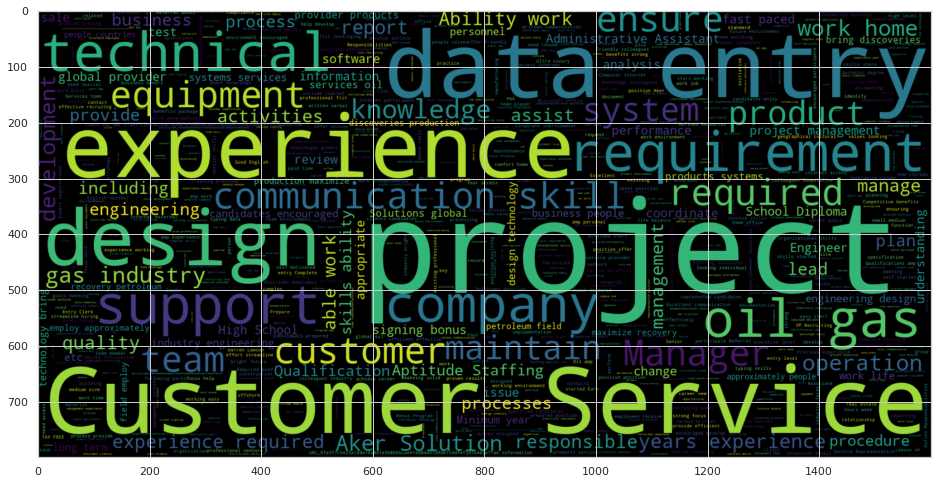

In [36]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3100 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [37]:
!pip install spacy && python -m spacy download en

2021-05-27 08:28:17.553084: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.7MB 307kB/s 
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [38]:
punctuations = string.punctuation

nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    mytockens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
    
def clean_text(text):
    return text.strip().lower()

In [39]:
df['text'] = df['text'].apply(clean_text)

In [40]:
df.head()

,fraudulent,text
0,0,"marketing intern we're food52, and we've creat..."
1,0,customer service - cloud video production 90 s...
2,0,commissioning machinery assistant (cma) valor ...
3,0,account executive - washington dc our passion ...
4,0,bill review manager spotsource solutions llc i...


In [41]:
df['text']

0        marketing intern we're food52, and we've creat...
1        customer service - cloud video production 90 s...
2        commissioning machinery assistant (cma) valor ...
3        account executive - washington dc our passion ...
4        bill review manager spotsource solutions llc i...
                               ...                        
17875    account director - distribution  vend is looki...
17876    payroll accountant weblinc is the e-commerce p...
17877    project cost control staff engineer - cost con...
17878    graphic designer  nemsia studios is looking fo...
17879    web application developers vend is looking for...
Name: text, Length: 17880, dtype: object

In [42]:
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df.drop(["text"], axis=1, inplace=True)
main_df = pd.concat([df1,df], axis=1)

In [43]:
main_df.head()

,ability,about,all,also,amp,an,and,are,as,at,based,be,best,business,but,by,can,client,clients,communication,company,customer,customers,data,design,development,do,environment,experience,for,from,full,has,have,help,high,if,in,including,industry,...,product,products,project,provide,quality,re,required,sales,service,services,skills,software,solutions,strong,support,team,technical,technology,that,the,their,this,through,time,to,up,us,we,web,well,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041120,0.000000,0.042424,0.036488,0.000000,0.755238,0.000000,0.078653,0.000000,0.000000,0.000000,0.043071,0.034178,0.040130,0.131541,0.000000,0.000000,0.000000,0.037122,0.031382,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.023411,0.081456,0.000000,0.039904,0.086128,0.054325,0.000000,0.00000,0.0,0.238944,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.12972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127976,0.053706,0.0,0.041037,0.000000,0.291636,0.069614,0.000000,0.000000,0.032185,0.184005,0.000000,0.000000,0.204948,0.000000,0.040199,0.000000,0.000000,0.186067,0.051026,0.068029,0.000000,0.000000,0.000000,0.000000,0
1,0.021895,0.094183,0.035394,0.024292,0.041787,0.029771,0.490896,0.056626,0.060050,0.052431,0.043397,0.043898,0.000000,0.078283,0.000000,0.075322,0.085429,0.053200,0.048722,0.021256,0.000000,0.115046,0.000000,0.0,0.0,0.000000,0.051697,0.022003,0.093836,0.151587,0.089252,0.000000,0.098635,0.062214,0.000000,0.04378,0.0,0.193831,0.136651,0.000000,...,0.025735,0.0,0.174234,0.000000,0.050263,0.00000,0.000000,0.000000,0.220411,0.000000,0.017473,0.025821,0.000000,0.000000,0.000000,0.046129,0.0,0.000000,0.107736,0.453268,0.000000,0.070882,0.000000,0.018429,0.152191,0.000000,0.019987,0.130395,0.026812,0.000000,0.000000,0.078004,0.165735,0.043827,0.116862,0.099327,0.000000,0.204854,0.130452,0
2,0.000000,0.000000,0.176807,0.000000,0.041749,0.089231,0.397029,0.113149,0.000000,0.000000,0.000000,0.029239,0.000000,0.000000,0.000000,0.037626,0.000000,0.159456,0.000000,0.000000,0.071812,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.116499,0.035668,0.000000,0.049272,0.000000,0.000000,0.00000,0.0,0.113914,0.000000,0.050261,...,0.000000,0.0,0.058025,0.046249,0.050217,0.00000,0.000000,0.000000,0.000000,0.219864,0.069826,0.000000,0.048159,0.094592,0.048809,0.000000,0.0,0.000000,0.215275,0.524358,0.000000,0.000000,0.048008,0.000000,0.350889,0.000000,0.000000,0.026055,0.000000,0.000000,0.000000,0.062346,0.307512,0.058383,0.000000,0.000000,0.000000,0.094462,0.074476,0
3,0.023267,0.000000,0.018806,0.000000,0.000000,0.094909,0.695542,0.000000,0.031906,0.037144,0.000000,0.015550,0.000000,0.145581,0.024418,0.020010,0.000000,0.000000,0.000000,0.022588,0.019095,0.024451,0.054739,0.0,0.0,0.045661,0.054937,0.070146,0.085471,0.123912,0.000000,0.000000,0.000000,0.016528,0.022762,0.00000,0.0,0.084814,0.096809,0.053459,...,0.000000,0.0,0.000000,0.049192,0.053412,0.00000,0.024291,0.173103,0.000000,0.023385,0.018567,0.000000,0.051223,0.025153,0.025957,0.065359,0.0,0.099884,0.049066,0.278862,0.042360,0.000000,0.127657,0.019584,0.335896,0.023612,0.000000,0.069283,0.000000,0.000000,0.023132,0.049735,0.075480,0.046573,0.000000,0.105551,0.019806,0.050236,0.059411,0
4,0.000000,0.000000,0.068009,0.000000,0.040147,0.028602,0.606379,0.081605,0.115386,0.000000,0.000000,0.028117,0.094780,0.037605,0.000000,0.000000,0.000000,0.051112,0.000000,0.040844,0.069056,0.044212,0.049490,0.0,0.0,0.041282,0.000000,0.000000,0.051516,0.201651,0.000000,0.043906,0.047382,0.000000,0.000000,0.00000,0.0,0.394354,0.043762,0.000000,...,0.000000,0.0,0.000000,0.000000,0.144870,0.00000,0.000000,0.000000,0.084704,0.169141,0.000000,0.000000,0.092621,0.000000,0.000000,0.029545,0.0,0.000000,0.029574,0.275038,0.000000,0.000000,0.000000,0.035412,0.269940,0.000000,0.000000,0.050111,0.000000,0.044230,0.000000,0.000000,0.159230,0.028071,0.037425,0.000000,0.035814,0.030279,0.107427,0


In [44]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12516, 100)
(12516,)
(5364, 100)
(5364,)


In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_train,y_train)

In [46]:
pred = rfc.predict(X_test)
score = accuracy_score(y_test, pred)
score

0.9683072334079046

In [47]:
print("Classification Report\n")
print(classification_report(y_test, pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test, pred))

Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5098
           1       0.98      0.37      0.54       266

    accuracy                           0.97      5364
   macro avg       0.97      0.68      0.76      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5096    2]
 [ 168   98]]
